# Statistical Tests on NHANES datasets

### ANOVA Test

We have obtained a dataset from the NHANES P_BMX and P_ECQ datasets that consists of Body Mass Index (BMI) and the WHQ030E (Parent's perception about child's weight), each of them corresponding to the respondent (SEQN).
Is there any evidence of a significant difference in BMI for children of different weight categories as per the parent's consideration?
The significance level is 5%.

To determine this, we are going to perform One-Way Anova test.

In [2]:
import pandas as pd
import random
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import ttest_ind
import duckdb as db
import matplotlib.pyplot as plt
import researchpy as rp

### Data Exploration and Preparation

Import the Early Childhood data

In [3]:
df_ECQ = pd.read_sas(
    '/Users/soumyadeepray/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research_Project-Nutrition_Sciences/NHANES/data/P_ECQ.XPT')

Fill null values with 9.0

In [4]:
df_ECQ['WHQ030E'] = df_ECQ['WHQ030E'].fillna(9.0)

Frequency of each of the categories in `WHQ030E` column

In [5]:
df_ECQ.groupby('WHQ030E').size()

WHQ030E
1.0     532
2.0     296
3.0    3549
9.0     988
dtype: int64

So, we have 4 groups in our independent variable. We need to remove the rows of the group 9.0 as it represents the repondents without a valid category.

In [6]:
df_ECQ.drop( df_ECQ[df_ECQ['WHQ030E']== 9.0].index, inplace=True)

Encoding the `WHQ030E` column with the descriptions of each of the eating occasions

In [7]:
df_ECQ['WHQ030E'] = df_ECQ['WHQ030E'].map({1.0 : 'Overweight',
                                    2.0 : 'Underweight',
                                    3.0 : 'Normal weight'})

Import the Body Measures data

In [8]:
df_BMX = pd.read_sas(
    '/Users/soumyadeepray/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research_Project-Nutrition_Sciences/NHANES/data/P_BMX.XPT')
df_BMX

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,BMXLEG,BMILEG,BMXARML,BMIARML,BMXARMC,BMIARMC,BMXWAIST,BMIWAIST,BMXHIP,BMIHIP
0,109263.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,109264.0,1.0,42.2,NaN,NaN,NaN,NaN,NaN,154.7,NaN,...,36.3,NaN,33.8,NaN,22.7,NaN,63.8,NaN,85.0,NaN
2,109265.0,1.0,12.0,NaN,91.6,NaN,NaN,NaN,89.3,NaN,...,NaN,NaN,18.6,NaN,14.8,NaN,41.2,NaN,NaN,NaN
3,109266.0,1.0,97.1,NaN,NaN,NaN,NaN,NaN,160.2,NaN,...,40.8,NaN,34.7,NaN,35.8,NaN,117.9,NaN,126.1,NaN
4,109269.0,3.0,13.6,NaN,90.9,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14295,124818.0,1.0,108.8,NaN,NaN,NaN,NaN,NaN,168.7,3.0,...,45.6,NaN,38.6,NaN,33.6,NaN,114.7,NaN,118.0,NaN
14296,124819.0,1.0,15.4,NaN,94.9,NaN,NaN,NaN,93.7,NaN,...,NaN,NaN,17.5,NaN,15.8,NaN,48.4,NaN,NaN,NaN
14297,124820.0,1.0,22.9,NaN,NaN,NaN,NaN,NaN,123.3,NaN,...,NaN,NaN,24.3,NaN,18.5,NaN,57.5,NaN,NaN,NaN
14298,124821.0,1.0,79.5,NaN,NaN,NaN,NaN,NaN,176.4,NaN,...,42.0,NaN,39.5,NaN,31.4,NaN,97.1,NaN,99.8,NaN


Join the Early Childhood dataframe with the Body Measures dataframe using SEQN as the joining condition and join type as left join.

In [9]:
df_merged = pd.merge(df_BMX, df_ECQ, on='SEQN', how='left')
df_merged

,SEQN,BMDSTATS,BMXWT,BMIWT,BMXRECUM,BMIRECUM,BMXHEAD,BMIHEAD,BMXHT,BMIHT,...,BMIHIP,ECD010,ECQ020,ECD070A,ECD070B,ECQ080,ECQ090,WHQ030E,MCQ080E,ECQ150
0,109263.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,31.0,2.0,7.0,6.000000e+00,NaN,NaN,Normal weight,2.0,NaN
1,109264.0,1.0,42.2,NaN,NaN,NaN,NaN,NaN,154.7,NaN,...,NaN,19.0,2.0,6.0,5.397605e-79,NaN,NaN,Underweight,2.0,NaN
2,109265.0,1.0,12.0,NaN,91.6,NaN,NaN,NaN,89.3,NaN,...,NaN,9999.0,9.0,6.0,4.000000e+00,NaN,NaN,Underweight,2.0,NaN
3,109266.0,1.0,97.1,NaN,NaN,NaN,NaN,NaN,160.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,109269.0,3.0,13.6,NaN,90.9,NaN,NaN,NaN,NaN,1.0,...,NaN,20.0,2.0,7.0,5.000000e+00,NaN,NaN,Normal weight,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14295,124818.0,1.0,108.8,NaN,NaN,NaN,NaN,NaN,168.7,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14296,124819.0,1.0,15.4,NaN,94.9,NaN,NaN,NaN,93.7,NaN,...,NaN,26.0,2.0,7.0,1.000000e+00,NaN,NaN,Normal weight,2.0,NaN
14297,124820.0,1.0,22.9,NaN,NaN,NaN,NaN,NaN,123.3,NaN,...,NaN,16.0,1.0,7.0,6.000000e+00,NaN,NaN,Normal weight,2.0,NaN
14298,124821.0,1.0,79.5,NaN,NaN,NaN,NaN,NaN,176.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


SQL query to select the BMXBMI, BMDBMIC, WHQ030E where WHQ030E is not null and BMXBMI is not null.

In [10]:
q_1 = db.sql("select BMXBMI, BMDBMIC, WHQ030E as Child_Weight_Perception from df_merged where WHQ030E is not null and BMXBMI is not null").df()

Frequency of different child weight perception occasions

In [11]:
q_1.groupby('Child_Weight_Perception').size()

Child_Weight_Perception
Normal weight    3101
Overweight        499
Underweight       265
dtype: int64

In [12]:
q_1.reset_index(inplace=True)
q_1

,index,BMXBMI,BMDBMIC,Child_Weight_Perception
0,0,17.6,2.0,Underweight
1,1,15.0,2.0,Underweight
2,2,30.9,4.0,Overweight
3,3,14.4,2.0,Normal weight
4,4,18.6,2.0,Normal weight
...,...,...,...,...
3860,3860,21.2,4.0,Normal weight
3861,3861,15.8,2.0,Underweight
3862,3862,16.0,2.0,Normal weight
3863,3863,17.5,3.0,Normal weight


In [13]:
q_1.columns

Index(['index', 'BMXBMI', 'BMDBMIC', 'Child_Weight_Perception'], dtype='object')

We will do random sampling to choose 1000 from a total of 3865 responddents. We will use _random.sample_ function.

In [14]:
random.seed(42)
sample_id = random.sample(list(range(0,3865)), 1000)

In [15]:
sample_df = q_1[q_1['index'].isin(sample_id)].reset_index(drop=True)

In [16]:
sample_df

,index,BMXBMI,BMDBMIC,Child_Weight_Perception
0,1,15.0,2.0,Underweight
1,2,30.9,4.0,Overweight
2,6,16.2,2.0,Normal weight
3,8,18.3,4.0,Overweight
4,13,16.3,2.0,Normal weight
...,...,...,...,...
995,3848,15.5,2.0,Normal weight
996,3852,19.1,2.0,Underweight
997,3856,29.9,4.0,Overweight
998,3857,24.4,3.0,Normal weight


Keeping only the variables of interest - __Child_Weight_Perception__ and __BMXBMI__

In [17]:
sample_df = sample_df[['BMXBMI','Child_Weight_Perception']]
groups = sample_df.groupby('Child_Weight_Perception').count().reset_index()
groups

,Child_Weight_Perception,BMXBMI
0,Normal weight,803
1,Overweight,122
2,Underweight,75


### Normality Assumption Check

Before we perform the hypothesis test, we check if the assumptions for the one-way ANOVA hypothesis test are fulfilled. The samples are random and independent samples. 

Now, we check the normality assumption by plotting a normal probability plot (Q-Q plots) for each grouped variable.

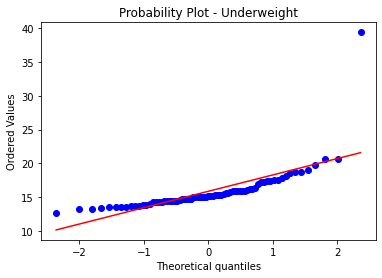

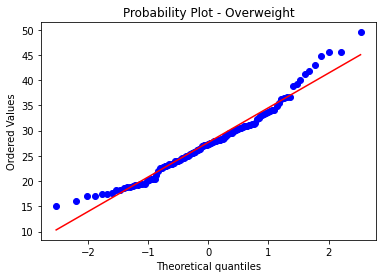

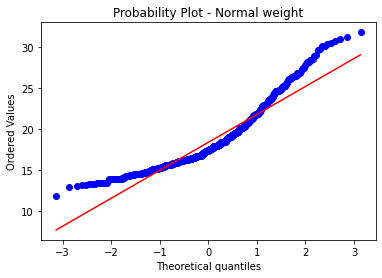

In [18]:
weight_groups = sample_df['Child_Weight_Perception'].unique()
for i in weight_groups:
    stats.probplot(sample_df[sample_df['Child_Weight_Perception'] == i]['BMXBMI'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  i)
    plt.show()

The Q-Q plot shows a largely straight-line pattern if it is from a normal distribution. From the above figure, we may assume that the data for each group falls roughly on a straight line.

### Homogeneity of variance Assumption Check

In [19]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = sample_df.groupby('Child_Weight_Perception').std().max() / sample_df.groupby('Child_Weight_Perception').std().min()
ratio

BMXBMI    2.108908
dtype: float64

The ratio of the largest to the smallest sample standard deviation is 2.108. That is greater than the threshold of 2. Therefore the homegeneity of variance assumption is not fulfilled.

In [20]:
stats.levene(sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Underweight'],
             sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Overweight'],
             sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Normal weight'])

LeveneResult(statistic=52.696023956421776, pvalue=1.757942342008102e-22)

### One way Anova

In [21]:
# model = ols('BMXBMI ~ C(Child_Weight_Perception)', data=sample_df).fit()
# aov_table = sm.stats.anova_lm(model, typ=2)
# aov_table

`summary_cont` returns a nice data table as a Pandas DataFrame that includes the variable name, total number of non-missing observations, standard deviation, standard error, and the 95% confidence interval.

In [22]:
rp.summary_cont(sample_df['BMXBMI'])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,BMXBMI,1000.0,19.3481,5.181,0.1638,19.0266,19.6696


In [23]:
rp.summary_cont(sample_df['BMXBMI'].groupby(sample_df['Child_Weight_Perception']))

,N,Mean,SD,SE,95% Conf.,Interval
Child_Weight_Perception,,,,,,
Normal weight,803,18.4047,3.5656,0.1258,18.1577,18.6517
Overweight,122,27.6869,6.8834,0.6232,26.4531,28.9207
Underweight,75,15.8840,3.2640,0.3769,15.1330,16.6350


`f_oneway` is the one-way ANOVA that tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [24]:
import scipy.stats as stats

f_value, p_value =  stats.f_oneway(sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Underweight'],
                                sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Overweight'],
                                sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Normal weight'])

# Print results
print("F-value:", f_value)
print("P-value:", p_value)

F-value: 301.1093605694674
P-value: 5.028814636009793e-103


### Conclusion

We see that through the One way Anova test, there is statistically significant difference between the different weight group means(F-value: 301.1093605694674, P-value: 5.028814636009793e-103)

But not all the assumptions of the Anova test is satisfied.

#### Referrence
__https://towardsdatascience.com/anova-test-with-python-cfbf4013328b__

__https://www.pythonfordatascience.org/anova-python/__

In [25]:
underweight_group = sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Underweight']
overweight_group = sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Overweight']
normalweight_group = sample_df['BMXBMI'][sample_df['Child_Weight_Perception'] == 'Normal weight']

For performing contrasts in ANOVA, we have used t-test to compare the means of three groups taken two at a time (pairwise t-test)

In [26]:
t_statistic1, p_value1 = ttest_ind(underweight_group, overweight_group)
t_statistic2, p_value2 = ttest_ind(underweight_group, normalweight_group)
t_statistic3, p_value3 = ttest_ind(overweight_group, normalweight_group)

In [27]:
print("T-statistic (underweight_group vs. overweight_group):", t_statistic1)
print("P-value (underweight_group vs. overweight_group):", p_value1)

T-statistic (underweight_group vs. overweight_group): -13.909403800198467
P-value (underweight_group vs. overweight_group): 5.264986017543727e-31


In [28]:
print("T-statistic (underweight_group vs. normalweight_group):", t_statistic2)
print("P-value (underweight_group vs. normalweight_group):", p_value2)

T-statistic (underweight_group vs. normalweight_group): -5.895644620458927
P-value (underweight_group vs. normalweight_group): 5.3236730882012225e-09


In [29]:
print("T-statistic (overweight_group vs. normalweight_group):", t_statistic3)
print("P-value (overweight_group vs. normalweight_group):", p_value3)

T-statistic (overweight_group vs. normalweight_group): 22.994243453290277
P-value (overweight_group vs. normalweight_group): 7.366692611711988e-93


### Chi Square Test

Pearson’s chi-squared test is a statistical hypothesis test used in the analysis of contingency tables when the sample sizes are large. In simpler terms, this test is primarily used to examine whether two categorical variables are independent in influencing the test statistic.

The distribution of a categorical variable in a sample often needs to be compared with the distribution of a categorical variable in another sample.

Here, we will compare the distribution of BMDBMIC (BMI Category - Children/Youth) and WHQ030E (How do you consider your child's weight).

#### Hypothesis for the chi square test

The null hypothesis can be framed in the below manner: The grouping variables have no association or correlation amongst them.


The alternate Hypothesis goes as framed below: The variables are associated with each other and happen to have a correlation between the variables.

In [30]:
from scipy.stats import chi2_contingency
import numpy as np

In [33]:
q_1

,index,BMXBMI,BMDBMIC,Child_Weight_Perception
0,0,17.6,2.0,Underweight
1,1,15.0,2.0,Underweight
2,2,30.9,4.0,Overweight
3,3,14.4,2.0,Normal weight
4,4,18.6,2.0,Normal weight
...,...,...,...,...
3860,3860,21.2,4.0,Normal weight
3861,3861,15.8,2.0,Underweight
3862,3862,16.0,2.0,Normal weight
3863,3863,17.5,3.0,Normal weight


In [39]:
q_1['BMDBMIC'] = q_1['BMDBMIC'].map({1.0 : 'Underweight',
                                    2.0 : 'Normal weight',
                                    3.0 : 'Overweight',
                                    4.0 : 'Overweight'})

In [40]:
q_1['BMDBMIC'].value_counts()

Normal weight    2328
Overweight       1414
Underweight       123
Name: BMDBMIC, dtype: int64

In [38]:
q_1['Child_Weight_Perception'].value_counts()

Normal weight    3101
Overweight        499
Underweight       265
Name: Child_Weight_Perception, dtype: int64

Creating the contingency table:
A contingency table is a table that shows the distribution of one variable in rows and another variable in columns. One can create a contingency table using the numpy library.

In [41]:
contigency= pd.crosstab(q_1['BMDBMIC'], q_1['Child_Weight_Perception'])
contigency

Child_Weight_Perception,Normal weight,Overweight,Underweight
BMDBMIC,,,
Normal weight,2095,22,211
Overweight,929,476,9
Underweight,77,1,45


chi2_contingency function returns four values:

chi2_stat: the chi-square test statistic

p_val: the p-value of the test

dof: the degrees of freedom

ex: the expected values based on the null hypothesis

In [42]:
chi2_stat, p_val, dof, ex = chi2_contingency(contigency)

In [43]:
print(f"Chi-square statistic = {chi2_stat}")
print(f"P-value = {p_val}")
print(f"Degrees of freedom = {dof}")
print(f"Expected values = \n{ex}")

Chi-square statistic = 1068.2871265667493
P-value = 5.660675088788953e-230
Degrees of freedom = 4
Expected values = 
[[1867.82095731  300.56196636  159.61707633]
 [1134.49262613  182.55782665   96.94954722]
 [  98.68641656   15.88020699    8.43337646]]


#### Inference

The first value (1068.2871265667493) is the Chi-square statistic, followed by the p-value (5.660675088788953e-230), then comes the degrees of freedom (4), and lastly it outputs the expected frequencies as an array. Since all of the expected frequencies are greater than 5, the chi2 test results can be trusted. 

We can reject the null hypothesis as the p-value is less than 0.05. Thus, the results indicate that there is a relationship between parent's perception of child's weight and the BMI category of the child.